In [71]:
import cv2
import numpy as np
import torch
from torch import Tensor
from sklearn.model_selection import KFold
from torch.autograd import Variable
from torch.nn import functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

sb.set_context('talk')
sb.set_style('whitegrid')

##### 1. Data and Visualization 

In [72]:
# Load datasets

files = ['F','N','O','S','Z']
datasets = {}
for file in files:
    filename = 'eeg_data/'+file+'.csv'
    datasets[file] = pd.read_csv(filename)    

In [73]:
# Define a function to concat the sets

def concat_set(datasets,classes):
    output = pd.DataFrame()
    y = []
    for i,class_ in enumerate(classes):        
        sets = [datasets[file] for file in class_]          
        set_ = pd.concat(sets,axis=0)
        output = pd.concat([output,set_],axis=0)
        y = y + [ i for _ in range(100*len(class_))]
    return output,y     

In [74]:
# Concatenate datasets
# A:Z, B:O, C:N, D:F, E:S

classes = ['Z','O','N','F','S']

X,y = concat_set(datasets,classes)
desc_files = {'A':['Non-Epileptic','Eyes opened','100'],'B':['Non-Epileptic','Eyes closed','100'],
              'C':['Epileptic','Interictal','100'],'D':['Epileptic','Interictal','100'],'E':['Epileptic','Ictal','100']}
df = pd.DataFrame(desc_files)
df.index = ['Class','Sub-class','Samples']
df

,A,B,C,D,E
Class,Non-Epileptic,Non-Epileptic,Epileptic,Epileptic,Epileptic
Sub-class,Eyes opened,Eyes closed,Interictal,Interictal,Ictal
Samples,100,100,100,100,100


In [12]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,12.0,22.0,35.0,45.0,69.0,74.0,79.0,78.0,66.0,43.0,...,-31.0,-28.0,-21.0,-14.0,-14.0,-25.0,-28.0,-11.0,8.0,77.0
1,-56.0,-50.0,-64.0,-91.0,-135.0,-140.0,-134.0,-114.0,-115.0,-126.0,...,-63.0,-82.0,-114.0,-138.0,-159.0,-172.0,-180.0,-173.0,-162.0,-82.0
2,-37.0,-22.0,-17.0,-24.0,-31.0,-20.0,-5.0,14.0,31.0,31.0,...,-91.0,-52.0,-23.0,-14.0,-5.0,-3.0,7.0,3.0,4.0,82.0
3,-31.0,-43.0,-39.0,-39.0,-9.0,-5.0,18.0,7.0,-12.0,-42.0,...,-32.0,-32.0,-40.0,-23.0,-1.0,11.0,12.0,-6.0,10.0,33.0
4,14.0,26.0,32.0,25.0,16.0,8.0,8.0,12.0,11.0,19.0,...,1.0,-19.0,-29.0,-35.0,-51.0,-55.0,-58.0,-32.0,-6.0,-17.0


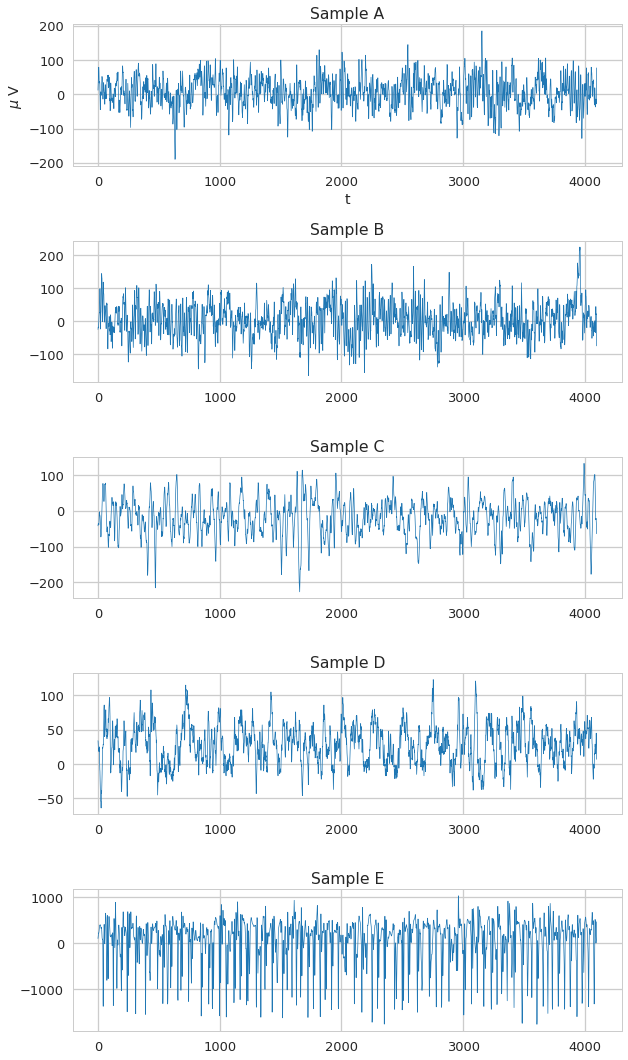

In [69]:
# Plot signals
fig,ax = plt.subplots(5,1,figsize=(9,15))

sb.set_context('talk')
sb.set_style('whitegrid')
label = ['A','B','C','D','E']
for i in range(5):
    msk = np.asarray(y) == i    
    ax[i].plot(X.values[msk,:][0],alpha=1,linewidth = 0.7,label=label[i])    
    ax[i].set_title('Sample '+label[i])
ax[0].set_xlabel('t')
ax[0].set_ylabel('$\mu$ V')
    
fig.tight_layout()

##### 2. CNN Model 

In [310]:
# Build a CNN class

class Net(nn.Module):
    def __init__(self,nb_class):
        super(Net,self).__init__()
        nb_hidden = 100
        self.conv1 = nn.Conv2d(1,16,kernel_size=(1,5),stride=3)
        self.conv2 = nn.Conv2d(16,24,kernel_size=(1,5),stride=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(24*6,nb_hidden)
        self.fc2 = nn.Linear(nb_hidden,nb_class)
        
    def forward(self,x):
        x = F.relu(F.max_pool2d((self.conv1(x)),kernel_size=(1,3)))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),kernel_size=(1,3)))        
        x = F.relu((self.fc1(x.view(-1,24*6))))
        x = F.dropout(x,training=self.training)
        x = F.softmax(self.fc2(x),1)        
        return x

In [311]:
   
# Define a function to create subsignals

def split_row(row,win_stride,win_size):
    new_set = []
    for i in range(0,row.shape[0],win_stride):
        if (i+win_size)>row.shape[0]: break
        new_set.append(row[i:i+win_size])
    tensor = Variable(Tensor(new_set).view(-1,1,1,win_size))
    return tensor
    
def split_rows(win_size,win_stride,data,targets):
    new_set = []
    new_targets = []
    for j,row in enumerate(data):
        for i in range(0,row.shape[0],win_stride):
            if (i+win_size)>row.shape[0]: break
            new_set.append(row[i:i+win_size])
            new_targets.append(targets[j])
    return new_set,new_targets

def ensemble_prediction(model,input):
    predictions = []    
    probs = model(input)
    pred = np.argmax(probs.data.mean(0))    
    return pred


def train_model(model,train_input,train_target,mini_batch_size):
    nb_epochs = 20
    eta = 1e-1
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=eta)
    avr_loss = []
    #print("Training the model...")
    for e in range(nb_epochs):
        sum_loss = 0
        for b in range(0,train_input.size(0),mini_batch_size):            
            a = mini_batch_size
            if (b+mini_batch_size)>train_input.size(0):
                a = train_input.size(0)-b     
            output = model(train_input.narrow(0,b,a)) 
            loss = criterion(output,train_target.narrow(0,b,a))
            sum_loss += loss.data[0]             
            model.zero_grad()
            loss.backward()
            optimizer.step()        
        avr_loss.append(sum_loss/mini_batch_size)
    return avr_loss

def compute_nb_errors(model,data_input,data_target):
  # data_target have to be a 1DTensor for Cross entropy loss
    output = model(data_input)
    _,pred = torch.max(output.data,1)
    #_,actual = torch.max(data_target.data,1)    
    acc = torch.mean((data_target.data== pred).float())
    return acc

def compute_nb_errors2(model,data_input,data_target,ratio):
  # data_target have to be a 1DTensor for Cross entropy loss   
    preds = []
    win_stride = int(ratio*512)
    win_size = 512
    for row in data_input:
        splits = split_row(row,win_stride,win_size)
        ansemble_pred = ensemble_prediction(model,splits)
        preds.append(ansemble_pred)        
    acc = np.mean(np.asarray(data_target)== np.asarray(preds))
    return acc,preds


In [312]:
# Split on train and test and normilize

train_input,test_input,train_target,test_target = train_test_split(X,y,test_size = 0.3)

train_input = (train_input-np.mean(train_input))/np.std(train_input)
test_input = (test_input-np.mean(test_input))/np.std(test_input)

# Set the windowing parameters using Scheme 1
win_size = 512
win_stride = 128
mini_batch_size = 100


train_input2,train_target2 = split_rows(win_size,win_stride,train_input.values,train_target)
test_input2,test_target2 = split_rows(win_size,win_stride,test_input.values,test_target)

train_input_var = Variable(Tensor(train_input2).view(-1,1,1,win_size))
train_target_var = Variable(Tensor(train_target2).long())


print('Number of sub-signals to train: ',len(train_input2))
print('Number of sub-signals to test: ',len(test_input2))


Number of sub-signals to train:  6090
Number of sub-signals to test:  2610


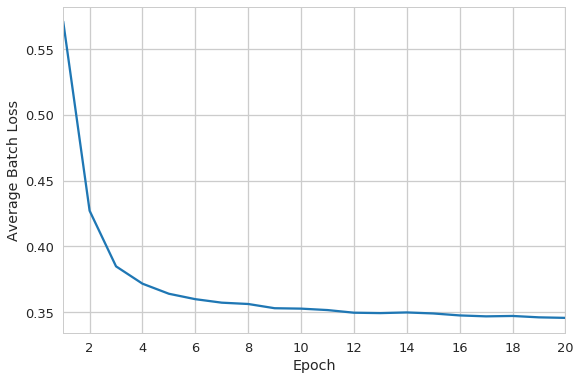

In [286]:
from matplotlib.ticker import MaxNLocator
# Training a CNN model
model = Net(3)
avg_loss = train_model(model,train_input_var,train_target_var,mini_batch_size)


fig, ax = plt.subplots(1,1,figsize=(9,6))
ax.plot(np.arange(1,21,dtype=np.int),avg_loss)
ax.set_xlabel("Epoch")
ax.set_ylabel('Average Batch Loss')
ax.set_xlim(1,20)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [287]:
test_acc, test_pred = compute_nb_errors2(model,test_input.values,test_target,0.25)
model.train(False)
train_acc,train_pred = compute_nb_errors2(model,train_input.values,train_target,0.25)

print("Acurácia de treino {:.2f}".format(train_acc))
print("Acurácia de teste {:.2f}".format(test_acc))

Acurácia de treino 0.99
Acurácia de teste 0.99


In [296]:
print("Predicted:",test_pred[:35])
print("Actual:   ",test_target[:35])
print('\n')
print("Predicted:",test_pred[35:70])
print("Actual:   ",test_target[35:70])
print('\n')
print("Predicted:",test_pred[70:])
print("Actual:   ",test_target[70:])

Predicted: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]
Actual:    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]


Predicted: [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
Actual:    [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]


Predicted: [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
Actual:    [1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]


In [297]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_target,test_pred))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99        61
          1       0.97      1.00      0.98        29

avg / total       0.99      0.99      0.99        90



In [6]:
mini_batch_size = 100
win_size = 512
win_stride = 128

In [ ]:
# Declare a function to perfome cros validation
def cross_val(X,y):
    kfold = KFold(n_splits=10,shuffle = True,random_state=100)

    y2 = np.asarray(y)
    count = 0
    train_accs = []
    test_accs = []
    for itrain,ival in kfold.split(X.values,y2):
        print('Computing kfold ',count+1)
        count += 1
        msk = np.random.choice(range(len(itrain)),size=len(itrain),replace=False)
        itrain = itrain[msk]
        train,val = X.iloc[itrain,:],X.iloc[ival,:]
        ytrain,yval = y2[itrain],y2[ival]   
            
        train = (train - np.mean(train))/np.std(train)
        val = (val - np.mean(val))/np.std(val)
        
        train_input,train_target = split_rows(win_size,win_stride,train.values,ytrain.tolist())   
        train_input_var = Variable(Tensor(train_input).view(-1,1,1,win_size))
        train_target_var = Variable(torch.LongTensor(np.array(train_target).tolist()))
        nb_class = len(set(y2))
        model = Net(nb_class)
        train_model(model,train_input_var,train_target_var,mini_batch_size)
    
    #    print('Testing the model...') 
        train_acc,_ = compute_nb_errors2(model,train.values,ytrain.tolist(),0.25)
        train_accs.append(train_acc)
        model.train(False)
        test_acc,_ = compute_nb_errors2(model,train.values,ytrain.tolist(),0.25)
        test_accs.append(test_acc)    
        
        #print("TrainAcc : {:.2f} ".format(train_accs[-1]))
        #print("TestAcc : {:.2f}".format(test_accs[-1]))
    print('Done\n')
    return train_accs,test_accs

#### Case 1: Normal vs Ictal

In [299]:
# Define the desired classes from the loaded sets 
# Z and O are sets related to the normal case and S to the ictal one

classes = [['Z','O'],['S']] 
X,y = define_classes(datasets,classes) 

# Show the dataframe size
X.shape

(300, 4097)

In [203]:
# Train a CNN model applying cross-validation
train_accs,test_accs = cross_val(X,y)

Computing kfold  1
Computing kfold  2
Computing kfold  3
Computing kfold  4
Computing kfold  5
Computing kfold  6
Computing kfold  7
Computing kfold  8
Computing kfold  9
Computing kfold  10
Done



In [204]:
# Compute the averate teste/train erro and its std

avr_train_acc, std_train_acc = np.mean(train_accs), np.std(train_accs)
avr_test_acc, std_test_acc = np.mean(test_accs), np.std(test_accs)

print("Average train accuracy: {:.2f}, std: {:.3f}".format(avr_train_acc,std_train_acc))
print("Average test accuracy: {:.2f}, std: {:.2f}".format(avr_test_acc,std_test_acc))

Average train accuracy: 0.99, std: 0.003
Average test accuracy: 0.96, std: 0.04


#### Case 2: Normal vs Interical vs Ictal

In [371]:
# Set the windowing parameters 

win_size = 512
win_stride = 128

classes = [['Z','O'],['N','F'],['S']]
X,y = define_classes(datasets,classes)
train_accs,test_accs = cross_val(X,y)

Computing kfold  1
Computing kfold  2
Computing kfold  3
Computing kfold  4
Computing kfold  5
Computing kfold  6
Computing kfold  7
Computing kfold  8
Computing kfold  9
Computing kfold  10
Done



In [372]:
# Compute the averate teste/train error and its std

avr_train_acc, std_train_acc = np.mean(train_accs), np.std(train_accs)
avr_test_acc, std_test_acc = np.mean(test_accs), np.std(test_accs)

print("Average train accuracy: {:.2f}, std: {:.3f}".format(avr_train_acc,std_train_acc))
print("Average test accuracy: {:.2f}, std: {:.2f}".format(avr_test_acc,std_test_acc))

Average train accuracy: 0.94, std: 0.030
Average test accuracy: 0.91, std: 0.07


In [313]:

classes = [['Z','O'],['N','F'],['S']]
X,y = define_classes(datasets,classes)
train_accs,test_accs = cross_val(X,y)

Computing kfold  1
Computing kfold  2
Computing kfold  3
Computing kfold  4
Computing kfold  5
Computing kfold  6
Computing kfold  7
Computing kfold  8
Computing kfold  9
Computing kfold  10
Done



In [314]:
# Compute the averate teste/train erro and its std

avr_train_acc, std_train_acc = np.mean(train_accs), np.std(train_accs)
avr_test_acc, std_test_acc = np.mean(test_accs), np.std(test_accs)

print("Average train accuracy: {:.2f}, std: {:.3f}".format(avr_train_acc,std_train_acc))
print("Average test accuracy: {:.2f}, std: {:.2f}".format(avr_test_acc,std_test_acc))

Average train accuracy: 0.93, std: 0.026
Average test accuracy: 0.93, std: 0.02


In [316]:
test_accs

[0.94888888888888889,
 0.94444444444444442,
 0.94444444444444442,
 0.9244444444444444,
 0.9044444444444445,
 0.93999999999999995,
 0.9244444444444444,
 0.87111111111111106,
 0.95111111111111113,
 0.9555555555555556]